In [3]:
import os.path as op
import warnings

import numpy as np
import pandas as pd
from scipy.signal import correlate, hilbert
import scipy.ndimage as nd

from scipy.signal import butter, lfilter
from scipy.stats import median_absolute_deviation

from utilities import reduce_df_mem_usage

from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
%matplotlib inline

rand_seed = 1234
rand_state = np.random.RandomState(rand_seed)

warnings.simplefilter(action='ignore', category=FutureWarning)

PATH = '/home/dhren/Documents/000_flatiron/002_projects/006_1028_kaggle_ASHRAE/data'

FIGSIZE = (22, 20)

In [ ]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1000**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

___

In [6]:
tmp = pd.read_csv(op.join(PATH, 'train.csv'))

In [48]:
size_dict = {3 : 'KB', 6 : 'MB', 9: 'GB'}
keys = list(size_dict.keys())

start_mem = tmp.memory_usage().sum()
key = keys[len(keys) - 1 - np.argmax(np.where(keys > (np.log10(start_mem) - 3), True, False)[::-1])]
print('Memory usage of dataframe is {:.4f} {:s}'.format(start_mem / 10**key, size_dict[key]))

Memory usage of dataframe is 0.6469 GB


In [49]:
tmp.memory_usage().sum() / 1000**2

646.915328

In [54]:
(keys > np.log10(start_mem)  - 3)[::-1]

array([ True,  True, False])

In [5]:
%%time

df_train = reduce_df_mem_usage(pd.read_csv(op.join(PATH, 'train.csv')))

#df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


CPU times: user 8.11 s, sys: 448 ms, total: 8.56 s
Wall time: 6.37 s


In [6]:
%%time

group = ['building_id', 'meter']
target = 'meter_reading'

#idx = df_train.building_id.isin([2, 922])
#df_train = df_train.loc[idx]

grp = df_train.groupby(group, sort = False)[[target]]
df_train[target + "_denoise"] = grp.transform(denoise)

/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/opt/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/miniconda3/envs/ml/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less_equal


CPU times: user 1min 42s, sys: 1.28 s, total: 1min 44s
Wall time: 30.8 s


/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in less


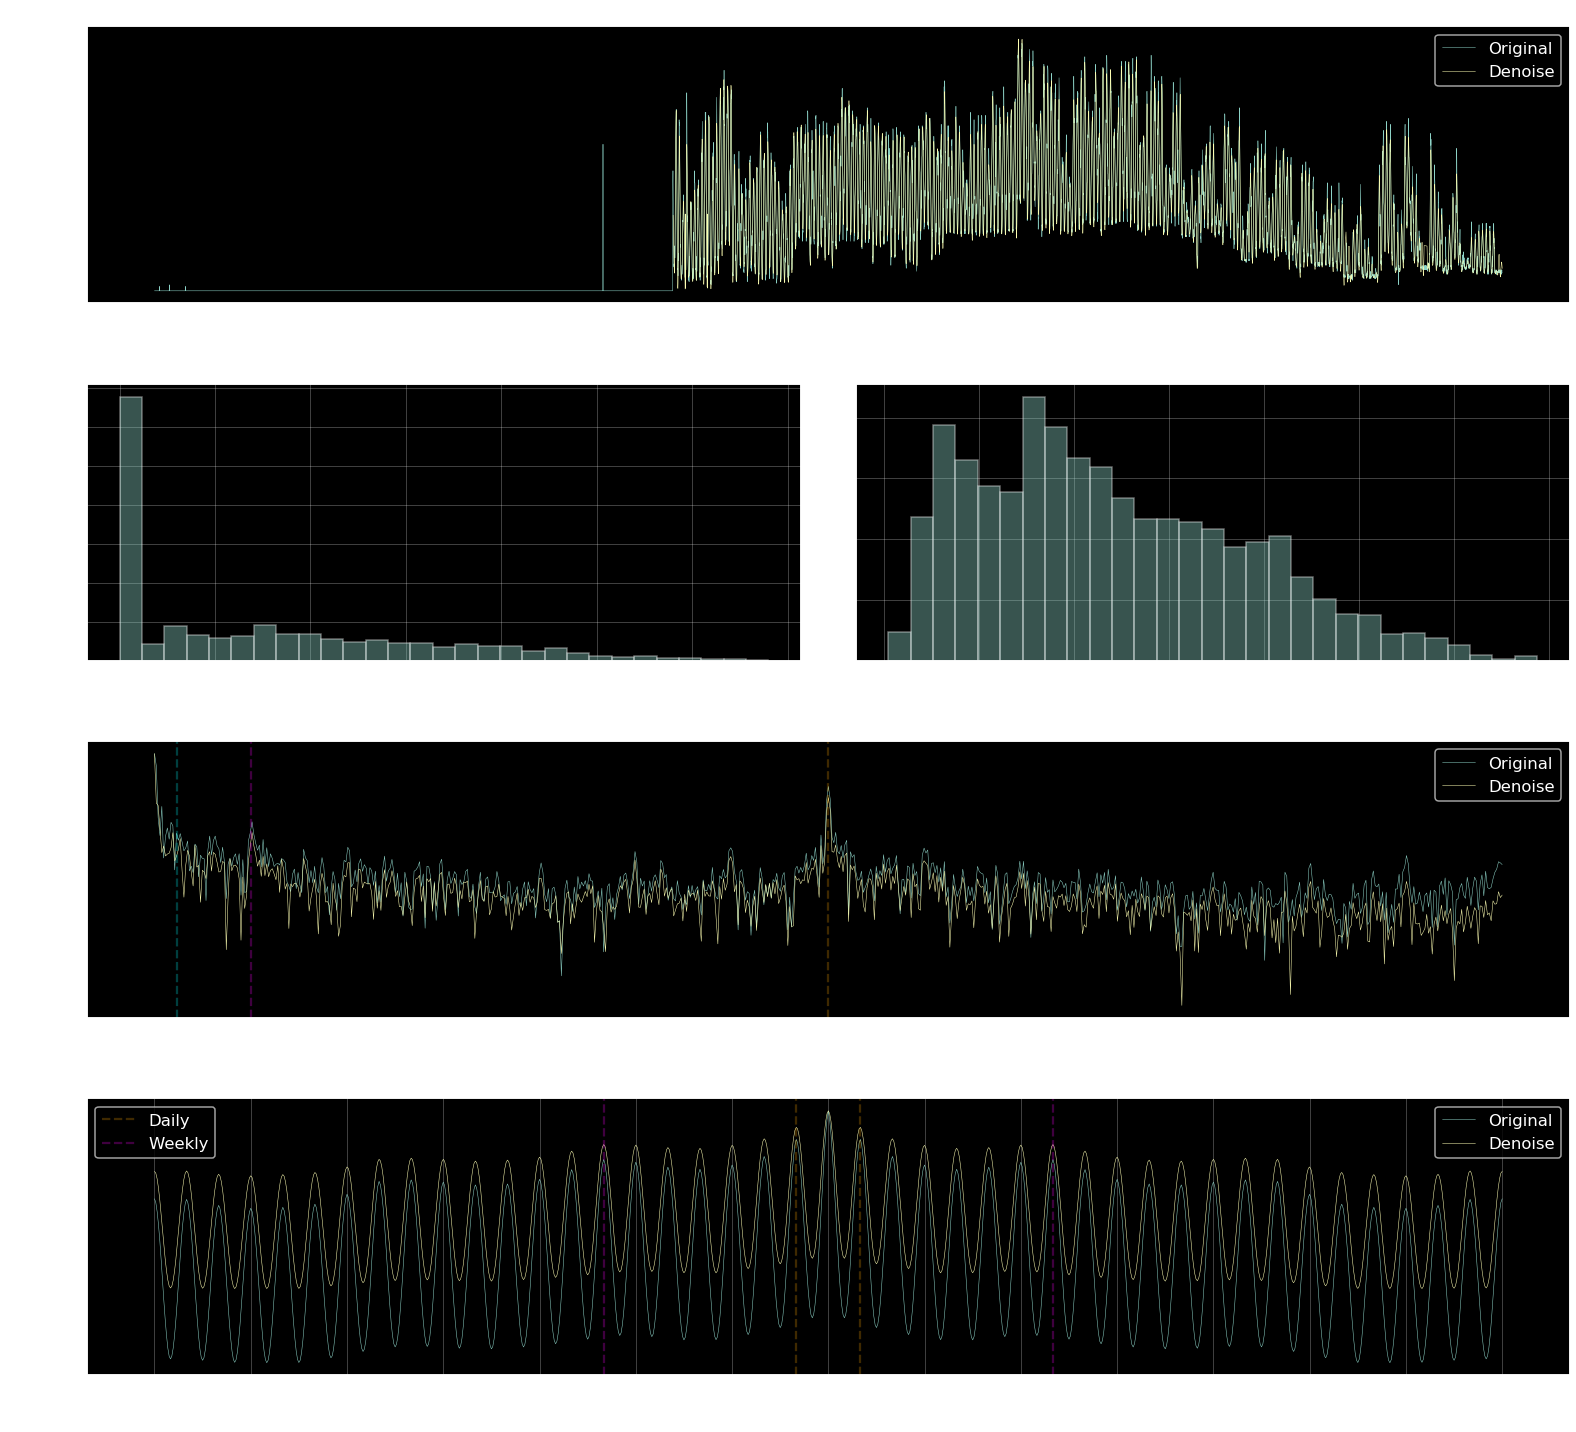

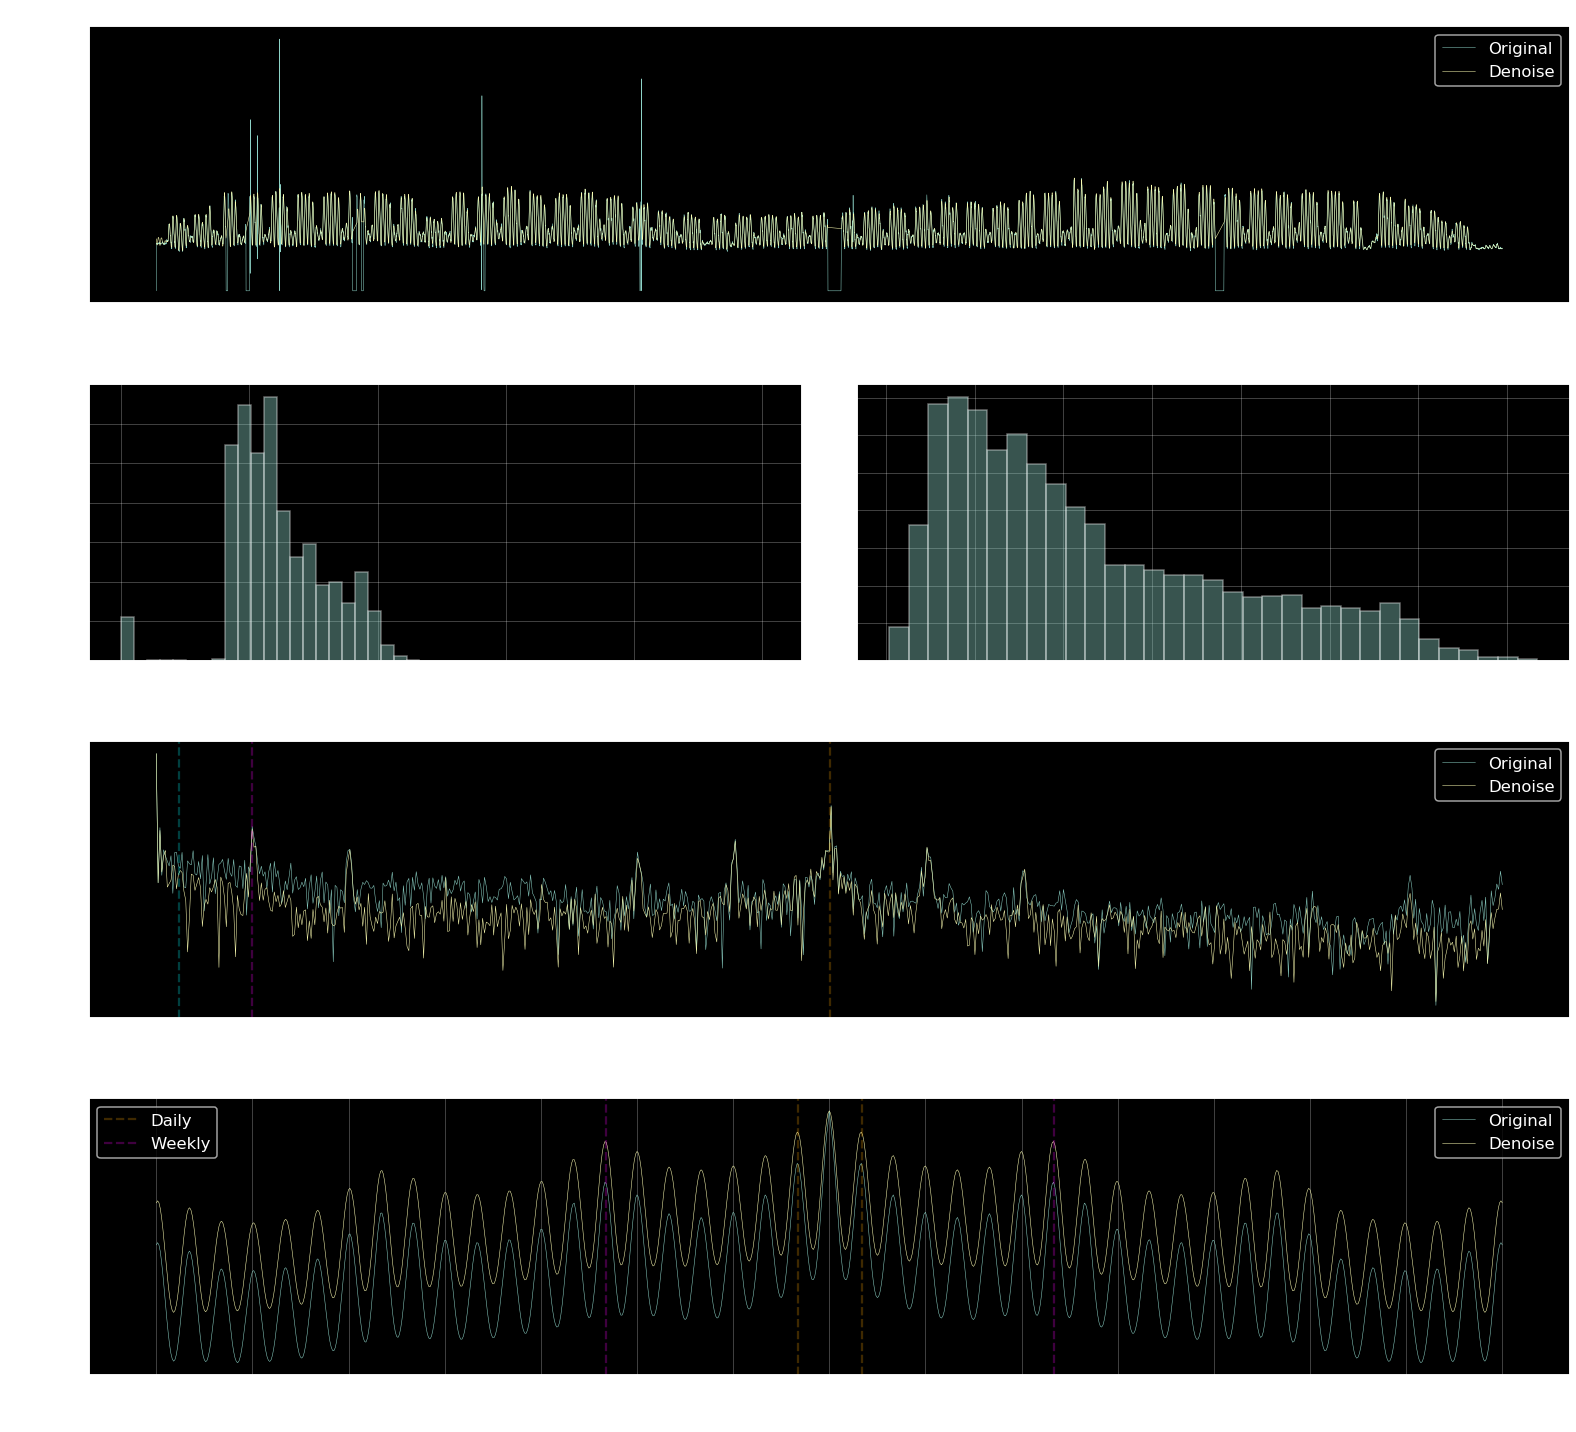

In [100]:
plot_meter(df_train, 2, 0)
plot_meter(df_train, 922, 0)

In [72]:
x = df_train[(df_train.building_id == 2) & (df_train.meter == 0)].timestamp

In [76]:
bol = np.zeros(len(x)).astype(bool)
bol[0] = True

In [79]:
x.iloc[bol]

2   2016-01-01
Name: timestamp, dtype: datetime64[ns]

In [101]:
%reset?

Docstring:
Resets the namespace by removing all names defined by the user, if
called without arguments, or by removing some types of objects, such
as everything currently in IPython's In[] and Out[] containers (see
the parameters for details).

Parameters
----------
-f : force reset without asking for confirmation.

-s : 'Soft' reset: Only clears your namespace, leaving history intact.
    References to objects may be kept. By default (without this option),
    we do a 'hard' reset, giving you a new session and removing all
    references to objects from the current session.

in : reset input history

out : reset output history

dhist : reset directory history

array : reset only variables that are NumPy arrays

See Also
--------
reset_selective : invoked as ``%reset_selective``

Examples
--------
::

  In [6]: a = 1

  In [7]: a
  Out[7]: 1

  In [8]: 'a' in get_ipython().user_ns
  Out[8]: True

  In [9]: %reset -f

  In [1]: 'a' in get_ipython().user_ns
  Out[1]: False

  In [2]: %re